### The purpose of this notebook is to compare and explore different imputation methods - it is not involved in the actual pipeline of the project

In [1]:
import numpy as np
import pandas as pd
import torch

from imputation_utils import *

# Import data

In [2]:
data, VARIABLES = import_data(discard_variables=True, discard_days=True, THRESHOLD=60)

discarded variables: ['GalvanicSkinResponse', 'ActivityClass']
discarded days (less than 60min of data): [312]
discarded days (sensor out all day): [114]


# Imputation

Format data into daily dataframes (for imputation model)

In [3]:
data_daily = data_to_days(data)

100%|██████████| 408/408 [02:29<00:00,  2.73it/s]


Normalize day-variable-wise

In [4]:
normalize_by_day(data_daily)

day 0 - ActivityCounts: mean: 1.2688263138573217e-17, std: 0.9999999999999959
day 0 - Barometer: mean: -5.938107148852266e-14, std: 0.9999999999999997
day 0 - BloodPerfusion: mean: 2.3770417019099194e-16, std: 1.000000000000001
day 0 - BloodPulseWave: mean: 1.092154295472125e-16, std: 1.0000000000000004
day 0 - EnergyExpenditure: mean: -5.075305255429287e-17, std: 1.0000000000000064
day 0 - HR: mean: -9.765144288927236e-16, std: 1.0
day 0 - HRV: mean: 1.5650721051984586e-16, std: 0.9999999999999997
day 0 - RESP: mean: -3.760906729921135e-16, std: 0.9999999999999998
day 0 - Steps: mean: -3.6478756523398e-17, std: 0.9999999999999938
day 0 - SkinTemperature: mean: 2.816794416763254e-15, std: 0.999999999999999
day 1 - ActivityCounts: mean: 0.0, std: 0.9999999999999909
day 1 - Barometer: mean: 7.088903107932162e-14, std: 0.9999999999999981
day 1 - BloodPerfusion: mean: -3.120978341552417e-17, std: 0.9999999999999994
day 1 - BloodPulseWave: mean: 6.241956683104833e-17, std: 0.999999999999999

### Explore imputation methods

In [5]:
# choose day
day = 400
data_day = data_daily[day]

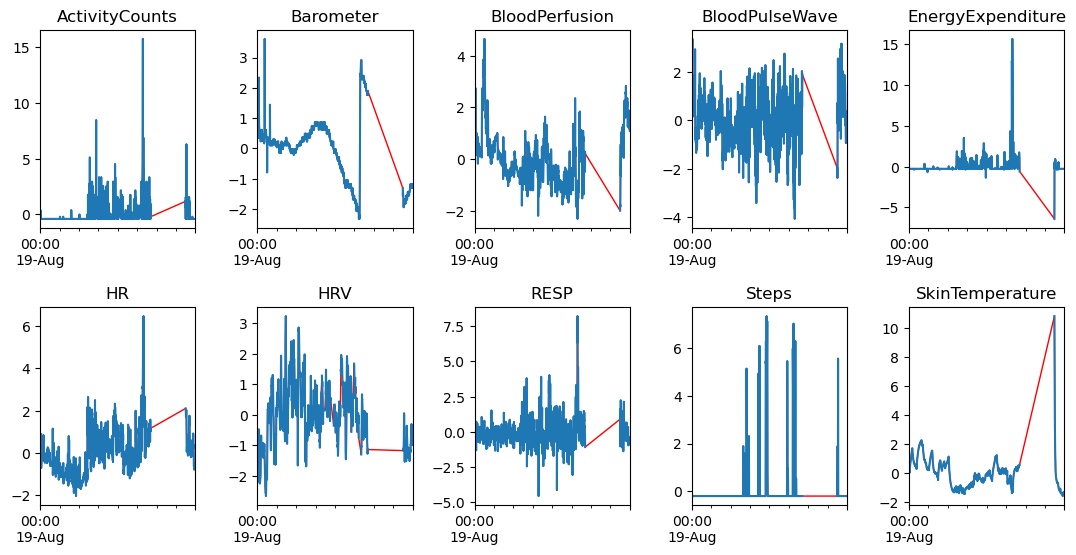

In [6]:
visualize_imputation(data_day, 'linear')

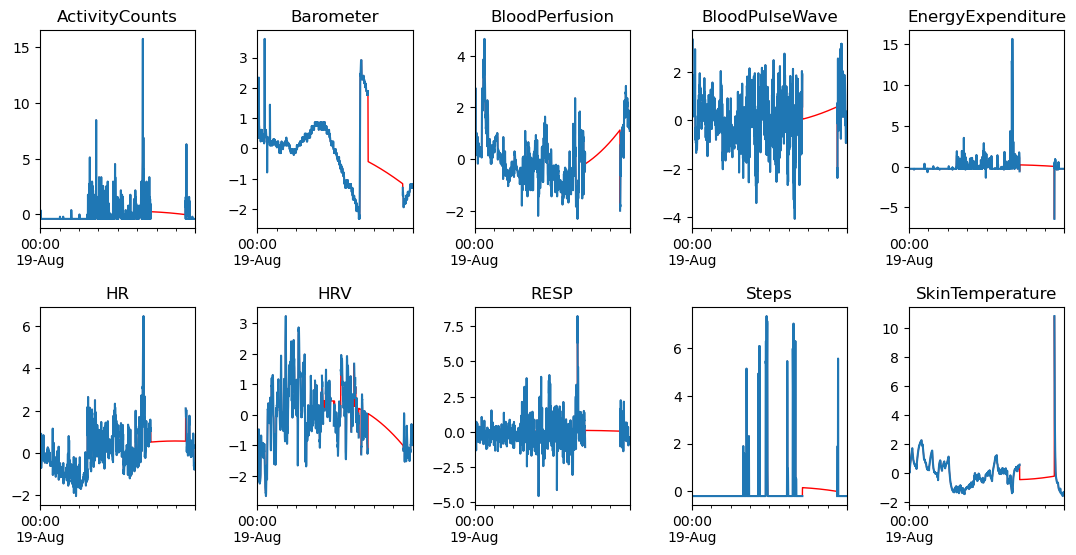

In [7]:
visualize_imputation(data_day, 'spline', order=2)

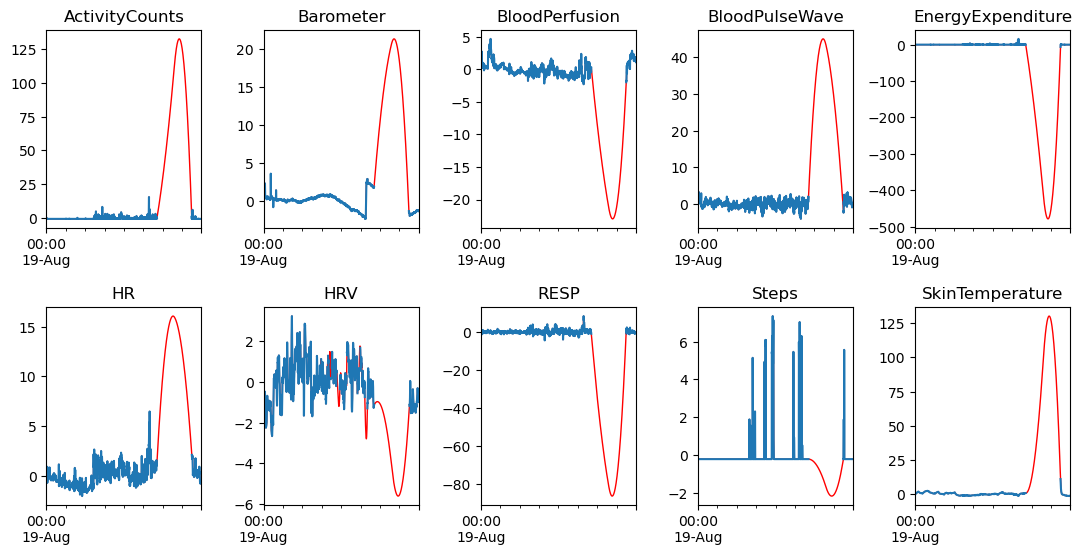

In [8]:
visualize_imputation(data_day, 'quadratic')

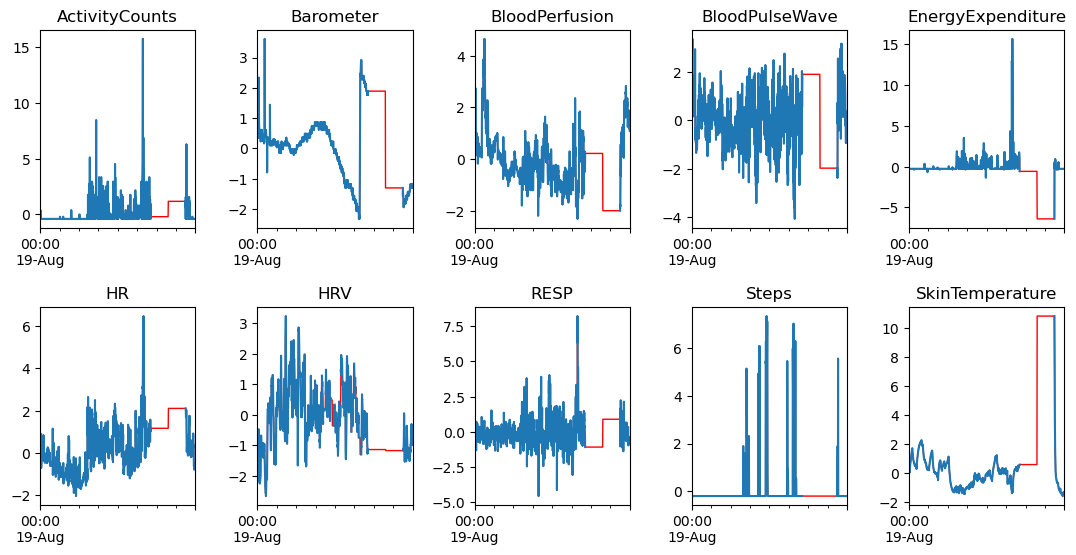

In [9]:
visualize_imputation(data_day, 'nearest')

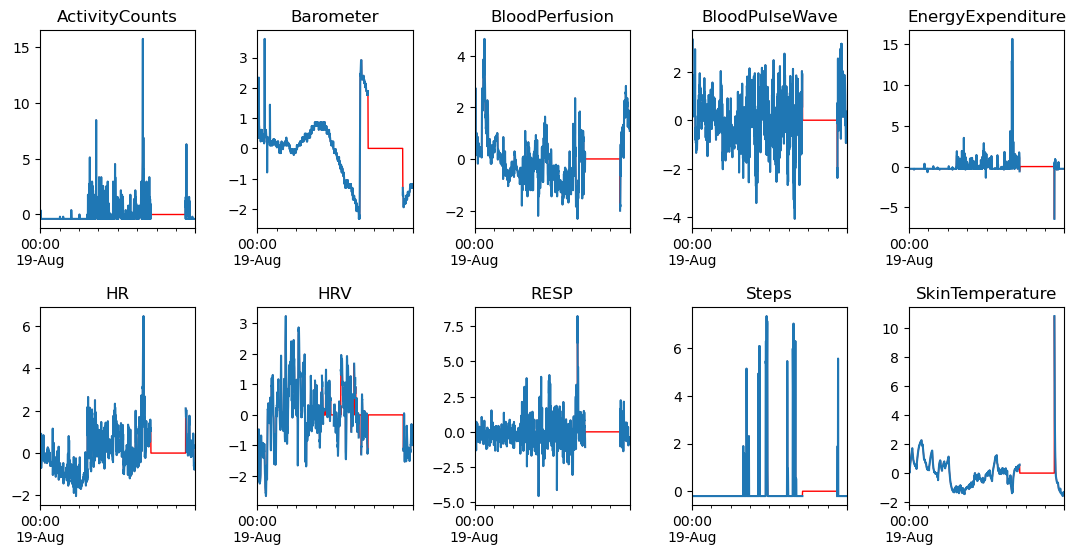

In [10]:
visualize_imputation(data_day, 'mean')

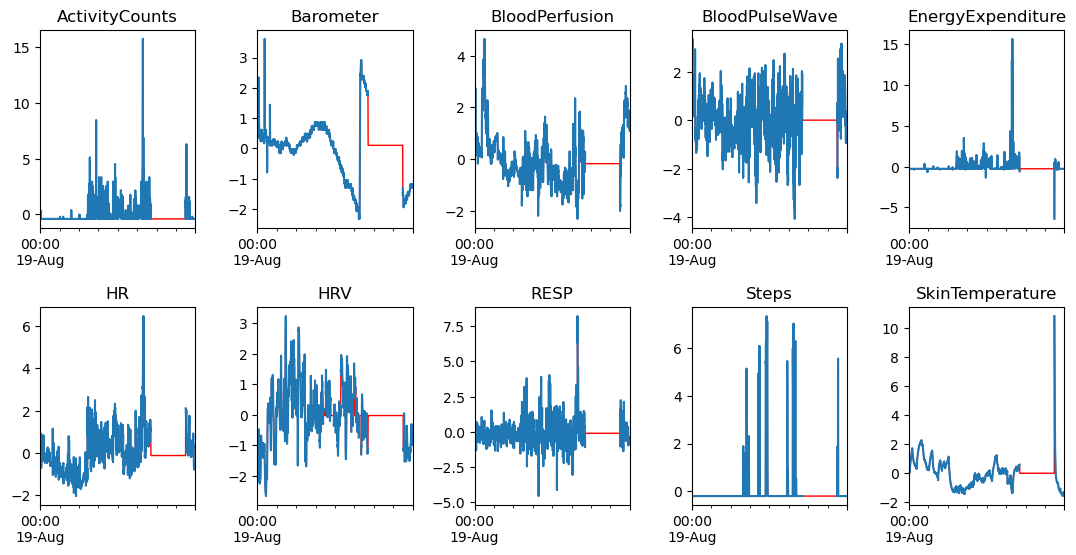

In [11]:
visualize_imputation(data_day, 'median')

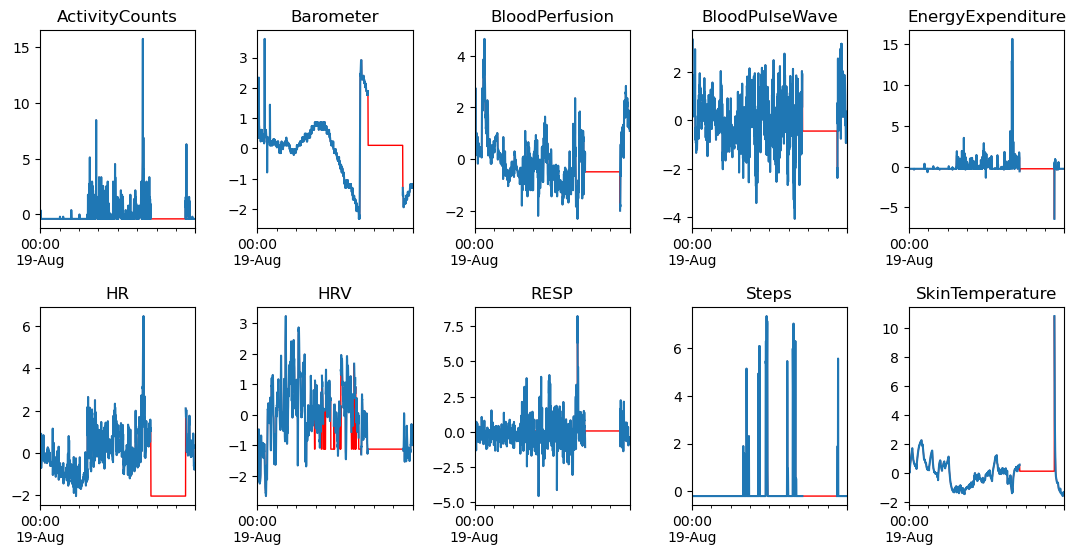

In [12]:
visualize_imputation(data_day, 'mode')

Note: general problem are long missing sequences, e.g.:

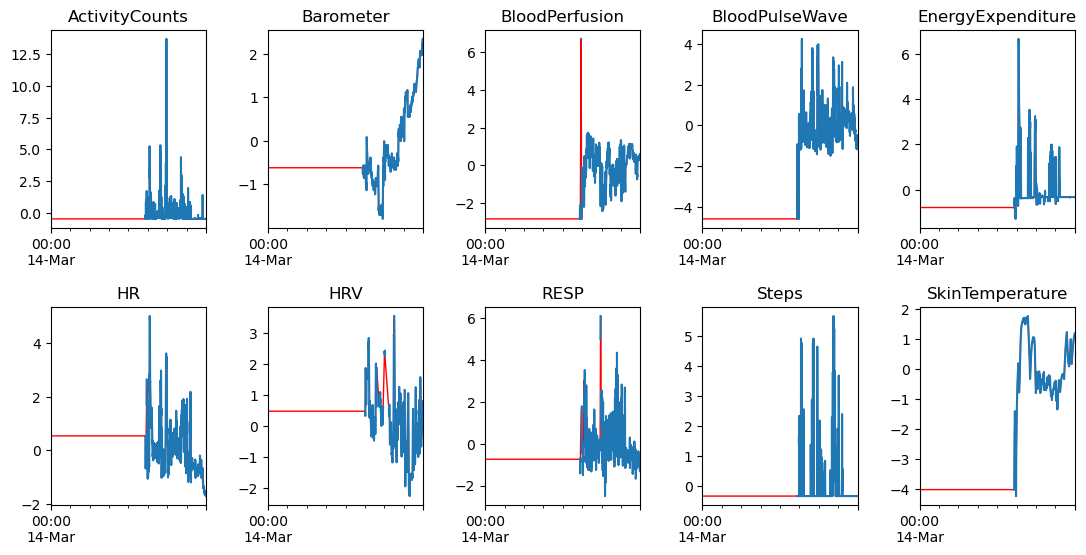

In [13]:
visualize_imputation(data_daily[0], 'linear')

Visualize mask

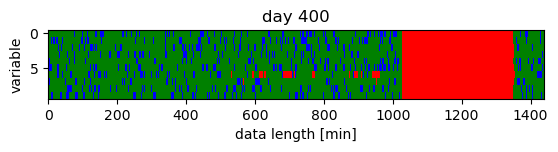

In [7]:
mask = masker(data_day, lm=3, masking_ratio=0.15)
visualize_mask(mask, day)

### Calculate mean sequence length & masking ratio in actual data

Mean sequence length: lm

In [ ]:
na_seqs = na_sequence_lengths(data)

In [ ]:
na_distribution = [[seq_length]*occurence for seq_length, occurence in na_seqs.to_numpy()]
na_distribution = [element for sublist in na_distribution for element in sublist]

In [ ]:
lm = np.mean(na_distribution) # mean masked sequence
lm

Masking ratio: masking_ratio

In [ ]:
# NaN -> 1.0, available data -> NaN
na_flipped = data.copy(deep=True)
n_days, _ = na_flipped.shape
for day in range(n_days):
    for variable in VARIABLES:
        time_series = get_time_series(na_flipped, variable, day)
        nas = np.isnan(time_series)
        time_series[:] = 1.0 # set full array to 1.0
        time_series[~nas] = np.NaN # set all elements that weren't NaN to NaN

        na_flipped[variable].iloc[day] = time_series

In [ ]:
non_na_seqs = na_sequence_lengths(na_flipped)

In [ ]:
non_na_distribution = [[seq_length]*occurence for seq_length, occurence in non_na_seqs.to_numpy()]
non_na_distribution = [element for sublist in non_na_distribution for element in sublist]

In [51]:
np.mean(non_na_distribution) # mean unmasked sequence

161.50465531381155

In [52]:
r = lm / (np.mean(non_na_distribution) + lm) # masking_ratio
r

0.21195370583292347

Visualize mask

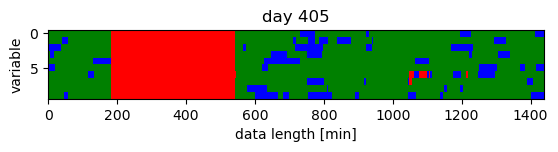

In [53]:
visualize_mask(masker(data_day, lm=lm, masking_ratio=r))

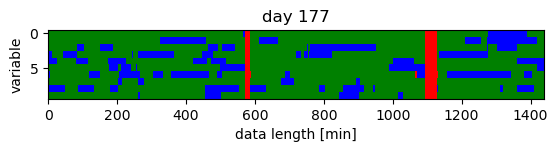

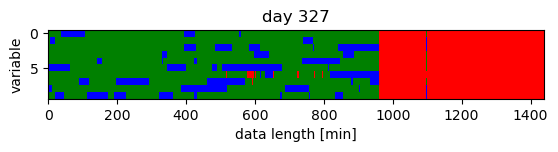

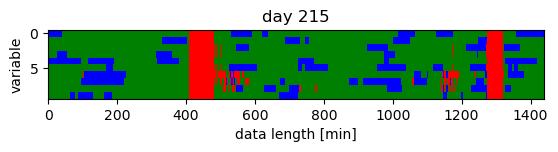

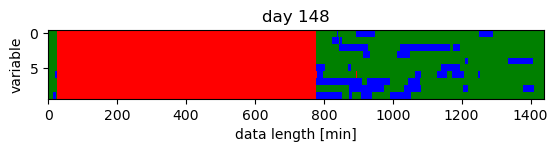

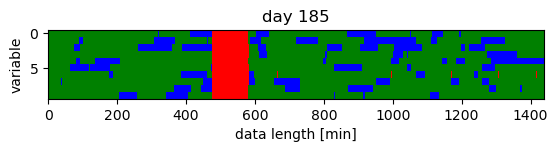

In [54]:
for i in range(5):
    day = np.random.choice(n_days, 1)[0]
    visualize_mask(masker(data_daily[day], lm=lm, masking_ratio=r))

### Scoring of methods

Numerical analysis

In [6]:
# short sequences
test_imputation_methods(data_daily, lm=3, masking_ratio=0.15)

[('linear', (0.2546989900955631, 0.0011065726614260195)),
 ('nearest', (0.2833264315384626, 0.0012309482785236808)),
 ('quadratic', (0.48154310114408166, 0.002092126202873499)),
 ('spline', (0.5730094528959055, 0.002489513582583833)),
 ('median', (0.631549212886187, 0.002743847131324569)),
 ('mean', (0.6781114089124404, 0.0029461426063057583)),
 ('mode', (0.7766532547319903, 0.0033742703839206543))]

In [7]:
# long sequences
test_imputation_methods(data_daily, lm=200, masking_ratio=0.15)

[('mode', (0.5011769114894004, 0.002044109747578171)),
 ('median', (0.5975793669180518, 0.0024372986481732938)),
 ('mean', (0.722937952078029, 0.0029485885739334457)),
 ('linear', (1.7400692283614811, 0.007097079673092157)),
 ('nearest', (1.741428057311821, 0.007102621818867441)),
 ('spline', (2.3304330013765746, 0.009504948661810926)),
 ('quadratic', (6562.385059761181, 26.765469359222255))]

In [57]:
# actual mean of data
test_imputation_methods(data_daily, lm=lm, masking_ratio=r)

[('nearest', (0.5083644934234958, 0.001839382851107746)),
 ('linear', (0.5230483201522551, 0.001892512405635893)),
 ('spline', (0.5432733990534853, 0.001965691519784278)),
 ('median', (0.5602454942578904, 0.0020271005703183095)),
 ('mode', (0.5762568469234104, 0.002085033427347059)),
 ('mean', (0.6300930530372725, 0.0022798255412251737)),
 ('quadratic', (19.49417889525959, 0.0705345452332682))]

In [7]:
'''def plotter_from_array(dat):
    """
    Same as plotter(day, dat) but here dat is array of daily data (shape: [1, 1440, 10])
    """
    if not isinstance(dat, np.ndarray):
        dat = dat.detach().numpy()

    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)
    batch_size, length, variables = dat.shape
    assert batch_size == 1 and length == 1440 and variables == 10

    # TODO: not sure if correct VARIABLES if we discard in import
    for i, variable in enumerate(VARIABLES):
        time_series = dat[:, :, i].reshape(-1)

        plt.subplot(3, 4, i+1)
        plt.title(variable)
        plt.plot(time_series)
        plt.xlim([0, length])'''

In [ ]:
'''# TODO: for now use batch_size = 1
# TODO: use dataloader?
# TODO: on GPU?
# TODO: evaluate only on purposefully set to NaN?
epochs = 50

model.train() # set model into training mode

history = {'train_loss': []}

print(f'Starting training for {epochs} epochs')
for epoch in range(epochs):
    # loss, metrics
    epoch_loss = 0.0

    # batches
    for i, batch_index in enumerate(tqdm(train_indices)):
        # load training batch
        batch = data_daily[batch_index].copy()

        # create mask (on-the-fly) # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)
        mask = masker(batch, lm=43, masking_ratio=0.21)

        # reshape
        mask = mask.transpose()
        batch = batch.transpose().to_numpy() # pandas -> numpy + reshape

        # mask missing data
        y_true = torch.tensor(batch).unsqueeze(0).float().to(device) # target values shouldn't be masked
        batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        batch = torch.tensor(batch).unsqueeze(0).float().to(device) # array -> tensor + add batch dimension
        X = batch

        # predict
        y_pred = model(X, padding_masks=torch.ones(1, 1440).bool().to(device)) # padding mask all True

        # update model
        mask = torch.tensor(mask == 1.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        #mask = torch.tensor(mask != 2.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        loss = criterion(y_pred, y_true, mask=mask)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        # on epoch end shuffle data
        np.random.shuffle(train_indices)

    # save data
    with torch.no_grad():
        history['train_loss'].append(epoch_loss)

    # print
    print(f'Epochs {epoch + 1}/{epochs} - loss: {epoch_loss}')'''

# Transformer imputation

In [6]:
# OPTIONAL: load data
"""train_data = np.load('Models/imputation_comparison/training_data6500.npy')
print(train_data.shape)
train_data = [pd.DataFrame(dat) for dat in train_data]

test_data = np.load('Models/imputation_comparison/test_data6500.npy')
print(test_data.shape)
test_data = [pd.DataFrame(dat) for dat in test_data]"""

(306, 10, 1440)
(102, 10, 1440)


### Model

In [38]:
sequence_length = 1440 # max: 1440 (full day)
d_model = 16
n_heads = 4
n_encoder_layers = 3
lm = 43
r = 0.21

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [40]:
"""lm = 3
r = 0.15"""

'lm = 3\nr = 0.15'

In [41]:
model = TSTransformerEncoder(feat_dim=len(VARIABLES),
                             max_len=sequence_length,
                             d_model=d_model,
                             n_heads=n_heads,
                             num_layers=n_encoder_layers,
                             dim_feedforward=d_model,
                             dropout=0.1,
                             pos_encoding='fixed',
                             activation='gelu',
                             norm='BatchNorm',
                             freeze=False)

model = model.to(device)

In [42]:
# OPTIONAL: load model
'''model = torch.load('./Models/transformer_imputation')'''

"model = torch.load('./Models/transformer_imputation')"

In [43]:
model

TSTransformerEncoder(
  (dropout1): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=16, out_features=10, bias=True)
  (project_inp): Linear(in_features=10, out_features=16, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, a

In [44]:
sum(p.numel() for p in model.parameters()) # TODO: less params (?) (or pruning afterwards?)

5434

### Data

In [45]:
# train-test split (TODO: + val?)
from sklearn.model_selection import train_test_split

n_days = len(data_daily)
train_indices, test_indices = train_test_split(np.arange(n_days), random_state=42)

In [46]:
data_daily[0].shape

(10, 1440)

### Training

In [47]:
# mask on-the-fly? -> model sees more data

In [48]:
epochs = 800
batch_size = 8

criterion = MaskedMSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
"""class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, indices):
        'Initialization'
        self.indices = indices

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.indices)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.indices[index]

        # Load data and get label
        X = data_daily[index].copy()
        mask = masker(X, lm=lm, masking_ratio=r).transpose
        X.transpose().to_numpy() # pandas -> numpy + reshape

        y_true = torch.tensor(X).float().to(device) # target values shouldn't be masked
        X[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        X = torch.tensor(X).float().to(device) # array -> tensor + add batch dimension

        return X, y_true"""

"class Dataset(torch.utils.data.Dataset):\n    'Characterizes a dataset for PyTorch'\n    def __init__(self, indices):\n        'Initialization'\n        self.indices = indices\n\n    def __len__(self):\n        'Denotes the total number of samples'\n        return len(self.indices)\n\n    def __getitem__(self, index):\n        'Generates one sample of data'\n        # Select sample\n        ID = self.indices[index]\n\n        # Load data and get label\n        X = data_daily[index].copy()\n        mask = masker(X, lm=lm, masking_ratio=r).transpose\n        X.transpose().to_numpy() # pandas -> numpy + reshape\n\n        y_true = torch.tensor(X).float().to(device) # target values shouldn't be masked\n        X[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer\n        X = torch.tensor(X).float().to(device) # array -> tensor + add batch dimension\n\n        return X, y_true"

In [50]:
"""train_dataset = Dataset(train_indices)
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=17, shuffle=True)"""

'train_dataset = Dataset(train_indices)\ntrain_generator = torch.utils.data.DataLoader(train_dataset, batch_size=17, shuffle=True)'

In [51]:
%%time
# segment day into sequences and treat as batches
model.train() # set model into training mode

history = {'train_loss': [],
           'test_loss': []}

print(f'Starting training for {epochs} epochs')
for epoch in tqdm(range(epochs)):
    # loss, metrics
    epoch_loss = 0.0
    epoch_loss_test = 0.0

    # training in batches
    np.random.shuffle(train_indices)
    n_batches = len(train_indices) // batch_size
    batches = np.split(train_indices[:batch_size * n_batches], n_batches)

    for i, batch_indices in enumerate(batches):

        batch = torch.zeros((batch_size, sequence_length, len(VARIABLES))).to(device)
        batch_mask = torch.zeros((batch_size, sequence_length, len(VARIABLES))).to(device)
        y_trues = torch.zeros((batch_size, sequence_length, len(VARIABLES))).to(device)
        for j, batch_index in enumerate(batch_indices):
            # load training batch
            full_day = data_daily[batch_index].copy()

            # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
            mask = masker(full_day, lm=lm, masking_ratio=r)

            # reshape
            full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
            mask = mask.transpose()

            # split day into batches
            """n_batches = full_day.shape[0] // sequence_length
            batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
            mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])"""

            # mask missing data
            y_true = torch.tensor(full_day).float().to(device) # target values shouldn't be masked
            full_day[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
            full_day = torch.tensor(full_day).float().to(device) # array -> tensor + add batch dimension
            X = full_day

            batch[j] = X
            batch_mask[j] = torch.tensor(mask)
            y_trues[j] = y_true

        # predict
        optimizer.zero_grad()
        y_pred = model(batch, padding_masks=torch.ones(batch_size, sequence_length).bool().to(device)) # padding mask all True

        # update model
        batch_mask = (batch_mask == 1.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        loss = criterion(y_pred, y_trues, mask=batch_mask)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        # on epoch end shuffle data
        np.random.shuffle(train_indices)

    # validation in batches
    with torch.no_grad():
        np.random.shuffle(test_indices)
        n_batches = len(test_indices) // batch_size
        batches = np.split(test_indices[:batch_size * n_batches], n_batches)

        for i, batch_indices in enumerate(batches):

            batch = torch.zeros((batch_size, sequence_length, len(VARIABLES))).to(device)
            batch_mask = torch.zeros((batch_size, sequence_length, len(VARIABLES))).to(device)
            y_trues = torch.zeros((batch_size, sequence_length, len(VARIABLES))).to(device)
            for j, batch_index in enumerate(batch_indices):
                # load training batch
                full_day = data_daily[batch_index].copy()

                # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
                mask = masker(full_day, lm=lm, masking_ratio=r)

                # reshape
                full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
                mask = mask.transpose()

                # split day into batches
                """n_batches = full_day.shape[0] // sequence_length
                batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
                mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])"""

                # mask missing data
                y_true = torch.tensor(full_day).float().to(device) # target values shouldn't be masked
                full_day[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
                full_day = torch.tensor(full_day).float().to(device) # array -> tensor + add batch dimension
                X = full_day

                batch[j] = X
                batch_mask[j] = torch.tensor(mask)
                y_trues[j] = y_true

            # predict
            y_pred = model(batch, padding_masks=torch.ones(batch_size, sequence_length).bool().to(device)) # padding mask all True

            # update model
            batch_mask = (batch_mask == 1.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
            loss = criterion(y_pred, y_trues, mask=batch_mask)
            epoch_loss_test += loss.item()

            # on epoch end shuffle data
            np.random.shuffle(test_indices)

    # save data
    with torch.no_grad():
        history['train_loss'].append(epoch_loss / (len(train_indices) // batch_size))
        history['test_loss'].append(epoch_loss_test / (len(test_indices) // batch_size))

    # print
    #print(f'Epochs {epoch + 1}/{epochs} - train loss: {epoch_loss / len(train_indices)}, test loss: {epoch_loss_test / len(test_indices)}')

Starting training for 800 epochs


100%|██████████| 800/800 [3:30:28<00:00, 15.79s/it]  

CPU times: total: 14h 25min 41s
Wall time: 3h 30min 28s


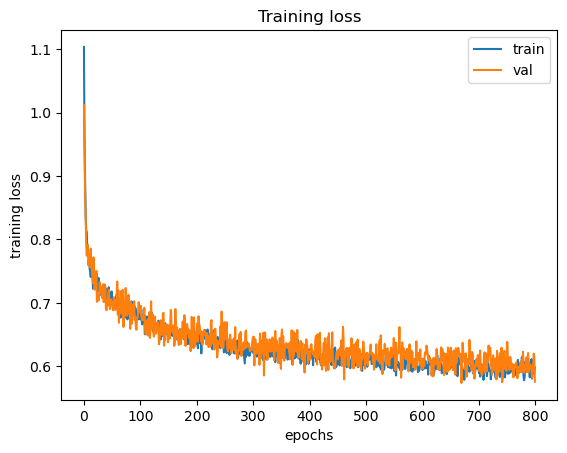

In [52]:
plt.plot(history['train_loss'])
plt.plot(history['test_loss'])
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Training loss')
plt.legend(['train', 'val'])

Below: epochs=6.5k, lm=43, r=0.21

In [14]:
%%time
# segment day into sequences and treat as batches
model.train() # set model into training mode

history = {'train_loss': [],
           'test_loss': []}

print(f'Starting training for {epochs} epochs')
for epoch in tqdm(range(epochs)):
    # loss, metrics
    epoch_loss = 0.0
    epoch_loss_test = 0.0

    # training in batches
    for i, batch_index in enumerate(train_indices):
        # load training batch
        full_day = data_daily[batch_index].copy()

        # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
        mask = masker(full_day, lm=lm, masking_ratio=r)

        # reshape
        full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
        mask = mask.transpose()

        # split day into batches
        n_batches = full_day.shape[0] // sequence_length
        batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
        mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

        # mask missing data
        y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
        batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
        batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
        X = batch

        # predict
        optimizer.zero_grad()
        y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

        # update model
        mask = torch.tensor(mask == 1.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        #mask = torch.tensor(mask != 2.0).unsqueeze(0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
        loss = criterion(y_pred, y_true, mask=mask)
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()

        # on epoch end shuffle data
        np.random.shuffle(train_indices)

    # validation in batches
    with torch.no_grad():
        for i, batch_index in enumerate(test_indices):
            # load training batch
            full_day = data_daily[batch_index].copy()

            # create mask (on-the-fly) (0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning))
            mask = masker(full_day, lm=43, masking_ratio=0.21)

            # reshape
            full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
            mask = mask.transpose()

            # split day into batches
            n_batches = full_day.shape[0] // sequence_length
            batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
            mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

            # mask missing data
            y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
            batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
            batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
            X = batch

            # predict
            y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

            # update model
            mask = torch.tensor(mask == 1.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
            #mask = torch.tensor(mask != 2.0).bool().to(device) # we don't evaluate on real missing data (False: ignore, True: calc. error)
            loss = criterion(y_pred, y_true, mask=mask)
            epoch_loss_test += loss.item()

            # on epoch end shuffle data
            np.random.shuffle(test_indices)

    # save data
    with torch.no_grad():
        history['train_loss'].append(epoch_loss / len(train_indices))
        history['test_loss'].append(epoch_loss_test / len(test_indices))

    # print
    #print(f'Epochs {epoch + 1}/{epochs} - train loss: {epoch_loss / len(train_indices)}, test loss: {epoch_loss_test / len(test_indices)}')

Starting training for 6500 epochs


100%|██████████| 6500/6500 [26:31:09<00:00, 14.69s/it]   

CPU times: total: 1d 2h 30min 3s
Wall time: 1d 2h 31min 9s


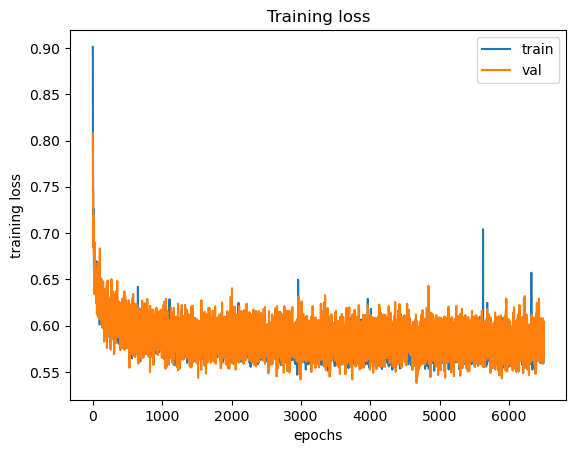

In [15]:
plt.plot(history['train_loss'])
plt.plot(history['test_loss'])
plt.xlabel('epochs')
plt.ylabel('training loss')
plt.title('Training loss')
plt.legend(['train', 'val'])

### Evaluation

### a) Visual inspection

In [53]:
day = np.random.choice(test_indices, 1)[0]
day

311

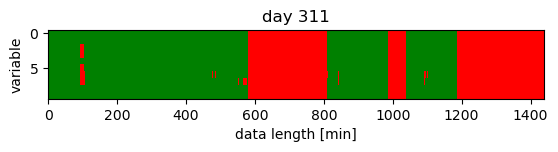

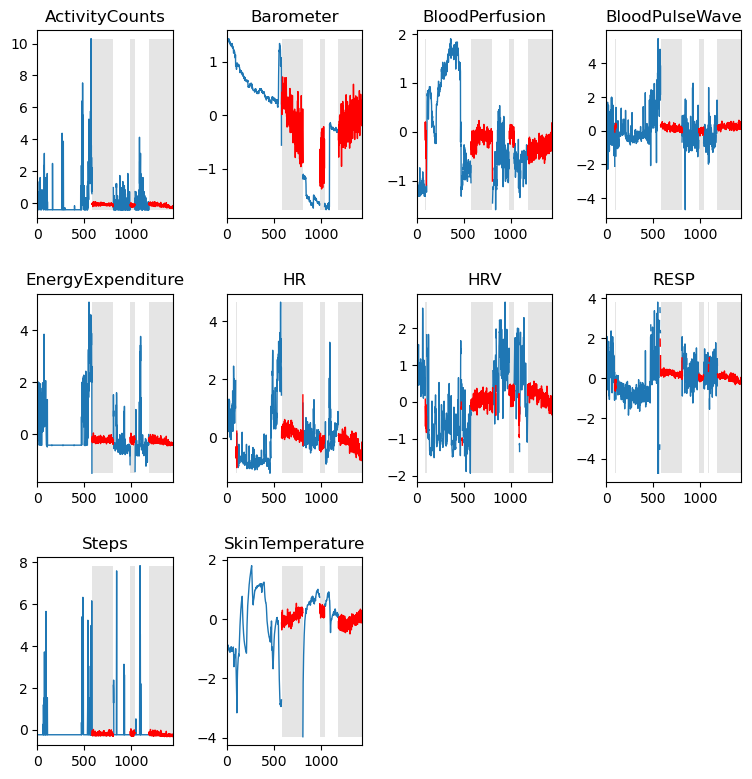

In [54]:
show_prediction(model, data_daily, day, lm=lm, r=r,
                show_mask=True, show_mask_plot=True,
                prediction_only=False, full_prediction=False,
                device=device)

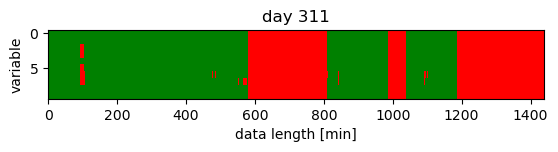

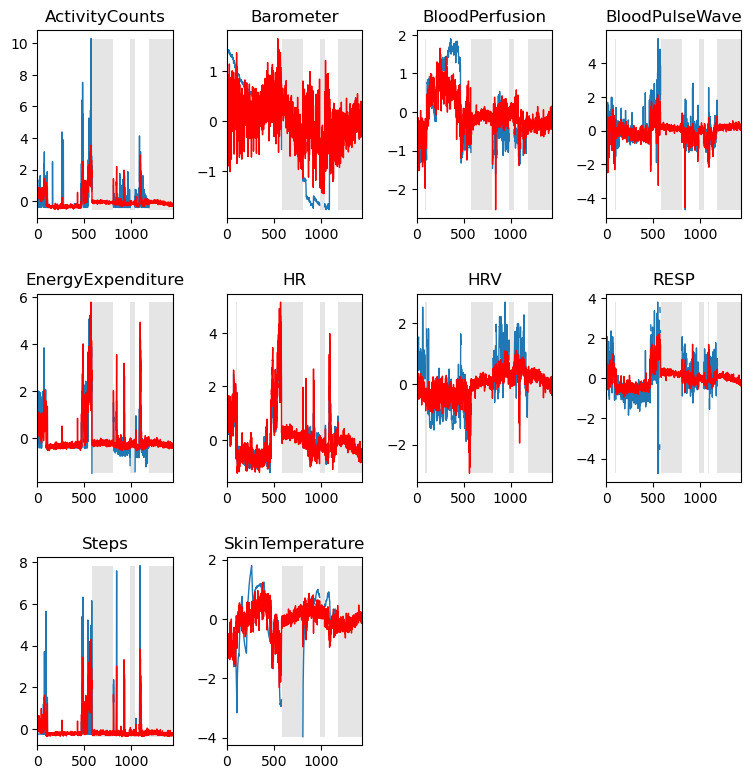

In [55]:
show_prediction(model, data_daily, day, lm=lm, r=r,
                show_mask=True, show_mask_plot=True,
                prediction_only=False, full_prediction=True,
                device=device)

### b) Test set

In [56]:
len(test_indices)

102

In [57]:
test_data = [data_daily[i] for i in test_indices]

evaluate n times

In [58]:
def test_imputation_methods(dat: list, lm=3, masking_ratio=0.15, model=None, device=None):
    """
    Tests all imputation methods
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mean absolute error (MAE) & mean relative error (MRE) on masked data (sorted dict)
    """
    n_days = len(dat)
    imputation_methods = ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest') if model is None else \
        ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest', 'transformer')

    # build masks
    mask_shape = dat[0].shape
    masks = np.zeros((n_days, *mask_shape))
    for day in range(n_days):
        masks[day] = masker(dat[day], lm=lm, masking_ratio=masking_ratio)

    # score each imputation method
    scores = {}
    for imputation_method in imputation_methods:
        imputation_errors = np.array([])
        reals = np.array([]) # for MRE
        for day in range(n_days):
            data_day = dat[day] # data for current day
            mask = masks[day] # mask for current day (all imputation methods use same masks)

            # impute masked data
            masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
            data_imputed = imputer(masked_data, imputation_method, order=2, model=model, device=device) # order for spline, device for transformer

            # calculate error
            real_data = data_day.to_numpy()[mask == 1.0]
            imputed_data = data_imputed.to_numpy()[mask == 1.0]

            # save
            imputation_errors = np.concatenate((imputation_errors,
                                                np.abs(real_data - imputed_data)),
                                               axis=None)
            reals = np.concatenate((reals, real_data), axis=None)

        mae = np.mean(imputation_errors) # MAE
        mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
        mre = mre[~np.isnan(mre)] # we ignore NaNs (if real value == 0, there is no relative error)
        mre = mre[~np.isinf(mre)] # we ignore infs (if real value ~= 0, the relative error can explode)
        mre = np.mean(mre)
        scores[imputation_method] = (mae, mre)

    return sorted(scores.items(), key=lambda x: x[1][0]) # sort by MAE

In [59]:
i = 0
n = 100
scores = []
while i < n:
    try:
        temp = test_imputation_methods(test_data,
                                   lm=lm,
                                   masking_ratio=r,
                                   model=model,
                                   device=device)
    except ValueError:
        continue
    if np.any(np.isnan(np.array([element[1] for element in temp]))):
       pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\AppData\Local\Temp\ipykernel_22632\239718275.py:43: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
C:\Users\jjung\AppData\Local\Temp\ipykernel_22632\239718275.py:43: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
C:\Users\jjung\AppData\Local\Temp\ipykernel_22632\239718275.py:43: RuntimeWarning: divide by zero encountered in true_divide
  mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
C:\Users\jjung\AppData\Local\Temp\ipykernel_22632\239718275.py:43: RuntimeWarning: divide by zero encountered in true_divide
  mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
C:\Users\jjung\AppData\Local\Temp\ipykernel_22632\239718275.py:43: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(imputation_errors), np.abs(reals)) # MRE
C:\Users\jjung\AppData\Local\Temp\ipykernel_2263

In [60]:
scores

[[('linear', (0.5041888337206863, 5.0070250287459475)),
  ('transformer', (0.5133347702501982, 2.995702428581327)),
  ('nearest', (0.5381318730405116, 5.231658720419099)),
  ('median', (0.6597470592067095, 2.0229552251813807)),
  ('spline', (0.665147505141949, 3.713340387225588)),
  ('mean', (0.7171493905498256, 1.4356379416580178)),
  ('mode', (0.9061951504186792, 6.731770226038839)),
  ('quadratic', (72.74820270395834, 490.81540396242326))],
 [('linear', (0.4947058360610589, 3.486972961895447)),
  ('transformer', (0.5238207906727885, 2.9626397093934265)),
  ('nearest', (0.5294497204121505, 4.148515062446601)),
  ('median', (0.6610679385270385, 2.1482803257041403)),
  ('mean', (0.7286788193206001, 1.4008085495319618)),
  ('mode', (0.8931864712481975, 5.972961828289361)),
  ('spline', (1.6211599342352159, 5.314071416651311)),
  ('quadratic', (193.65449148374103, 918.494300612387))],
 [('linear', (0.5082769290557552, 4.997119961159223)),
  ('transformer', (0.5246295452540066, 3.35020853

In [61]:
t = {'transformer': {'mae': [], 'mre': []},
     'linear': {'mae': [], 'mre': []},
     'nearest': {'mae': [], 'mre': []},
     'spline': {'mae': [], 'mre': []},
     'median': {'mae': [], 'mre': []},
     'mean': {'mae': [], 'mre': []},
     'mode': {'mae': [], 'mre': []},
     'quadratic': {'mae': [], 'mre': []}}
for round in scores:
    for evaluation in round:
        method, (mae, mre) = evaluation
        t[method]['mae'].append(mae)
        t[method]['mre'].append(mre)

In [62]:
scores_mae = pd.DataFrame.from_dict({key: value['mae'] for key, value in t.items()})
scores_mae

,transformer,linear,nearest,spline,median,mean,mode,quadratic
0,0.513335,0.504189,0.538132,0.665148,0.659747,0.717149,0.906195,72.748203
1,0.523821,0.494706,0.529450,1.621160,0.661068,0.728679,0.893186,193.654491
2,0.524630,0.508277,0.545734,5.288278,0.672331,0.730150,0.890169,181.117177
3,0.529917,0.509819,0.547648,0.730254,0.683272,0.738030,0.918376,77.074304
4,0.528450,0.510592,0.551916,0.661560,0.688774,0.749935,0.901345,253.767153
...,...,...,...,...,...,...,...,...
95,0.519633,0.514591,0.550967,0.839063,0.660650,0.727261,0.893211,82.705427
96,0.520881,0.503349,0.539558,0.761685,0.663877,0.725129,0.907187,228.221623
97,0.522070,0.512517,0.551119,0.676462,0.662580,0.723421,0.915695,70.608870
98,0.524598,0.506512,0.541613,0.737457,0.677980,0.737642,0.914520,110.879536


In [63]:
scores_mre = pd.DataFrame.from_dict({key: value['mre'] for key, value in t.items()})
scores_mre

,transformer,linear,nearest,spline,median,mean,mode,quadratic
0,2.995702,5.007025,5.231659,3.713340,2.022955,1.435638,6.731770,490.815404
1,2.962640,3.486973,4.148515,5.314071,2.148280,1.400809,5.972962,918.494301
2,3.350209,4.997120,6.561782,36.288629,2.646077,1.641282,6.321312,1050.848168
3,2.684325,3.818095,4.097131,3.779647,1.905140,1.510759,6.007198,391.599371
4,3.208061,4.852572,5.354475,2.983835,2.369059,1.588053,5.916272,1118.325126
...,...,...,...,...,...,...,...,...
95,2.480366,4.289009,5.109393,4.776833,1.914138,1.348589,6.032723,378.396925
96,2.700261,3.255337,3.848167,3.356606,1.737926,1.392691,6.348051,1044.432565
97,3.052690,4.436179,5.282793,3.697699,2.132362,1.360086,6.689711,428.221680
98,3.286656,4.192198,5.006210,3.588220,2.276156,1.556936,6.199733,560.203028


save scores (optional)

In [36]:
#with open(f'scores_mae{epochs}.txt','w') as dat:
    #dat.write(str(scores_mae))
#with open(f'scores_mre{epochs}.txt','w') as dat:
    #dat.write(str(scores_mre))

to Latex

In [64]:
# 1) MAE
# calculate mean, std
mae = scores_mae.mean().rename('MAE')
mae.index = [word.capitalize() for word in mae.index] # capitalize method names
mae_std = scores_mae.std()

# combine in each entry
n_rows = mae.shape[0]
for i in range(n_rows):
    mae.iloc[i] = str(np.round(mae.iloc[i], 4)) + ' ± ' + str(np.round(mae_std.iloc[i], 4))

# make smallest bold
index_max = np.argmin([float(entry.split('±')[0]) for entry in mae])
entry = mae.iloc[index_max]
entry = 'BOLD{' + entry + '}'
mae.iloc[index_max] = entry

# 2) MRE
# calculate mean, std
mre = scores_mre.mean().rename('MRE')
mre.index = [word.capitalize() for word in mre.index] # capitalize method names
mre_std = scores_mre.std()

# combine in each entry
n_rows = mre.shape[0]
for i in range(n_rows):
    mre.iloc[i] = str(np.round(mre.iloc[i], 4)) + ' ± ' + str(np.round(mre_std.iloc[i], 4))

# make smallest bold
index_max = np.argmin([float(entry.split('±')[0]) for entry in mre])
entry = mre.iloc[index_max]
entry = 'BOLD{' + entry + '}'
mre.iloc[index_max] = entry

# combine
df = pd.DataFrame([mae, mre]).transpose()

# sort by MAE
df.insert(1, 'temp', scores_mae.mean().to_numpy())
df = df.sort_values(by=['temp'])
df = df.drop(['temp'], axis=1)

# to latex
print(
    df.to_latex(
        index=True,
        bold_rows=True,
        caption=f'Imputation metrics (n=100) ({epochs} epochs)',
        position='H').replace('BOLD\\', r'\textbf').replace('\}', '}')
)

\begin{table}[H]
\centering
\caption{Imputation metrics (n=100) (800 epochs)}
\begin{tabular}{lll}
\toprule
{} &                    MAE &                    MRE \\
\midrule
\textbf{Linear     } &  \textbf{0.5082 ± 0.0085} &        3.9771 ± 0.5975 \\
\textbf{Transformer} &         0.524 ± 0.0046 &        2.8636 ± 0.3298 \\
\textbf{Nearest    } &        0.5443 ± 0.0093 &        4.4838 ± 0.7013 \\
\textbf{Median     } &         0.669 ± 0.0081 &        2.0956 ± 0.2381 \\
\textbf{Mean       } &        0.7304 ± 0.0067 &  \textbf{1.4237 ± 0.0996} \\
\textbf{Spline     } &         0.899 ± 0.5445 &         4.1404 ± 3.319 \\
\textbf{Mode       } &         0.904 ± 0.0145 &        6.1169 ± 0.5764 \\
\textbf{Quadratic  } &    274.2556 ± 807.3742 &  1312.5864 ± 2552.3848 \\
\bottomrule
\end{tabular}
\end{table}



C:\Users\jjung\AppData\Local\Temp\ipykernel_22632\2611795880.py:45: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


### Save model

In [20]:
torch.save(model, f'./Models/transformer_imputation{epochs}')

### Save data

In [336]:
np.save(f'./Models/training_data{epochs}', [data_daily[i] for i in train_indices])
np.save(f'./Models/test_data{epochs}', test_data)

### Analyse large/small sequences

In [317]:
def test_imputation_methods_by_sequence(dat: list, lm=3, masking_ratio=0.15, model=None, device=None):
    """
    Tests all imputation methods
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mean absolute error (MAE) & mean relative error (MRE) on masked data (sorted dict)
    """
    n_days = len(dat)
    imputation_methods = ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest') if model is None else \
        ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest', 'transformer')

    # build masks
    mask_shape = dat[0].shape
    masks = np.zeros((n_days, *mask_shape))
    for day in range(n_days):
        masks[day] = masker(dat[day], lm=lm, masking_ratio=masking_ratio)

    # score each imputation method
    scores = {imputation_method: {'small': None, 'medium': None, 'long': None} for imputation_method in imputation_methods}
    for imputation_method in imputation_methods:
        imputation_errors = []
        reals = [] # for MRE
        for day in range(n_days):
            data_day = dat[day] # data for current day
            mask = masks[day] # mask for current day (all imputation methods use same masks)

            # impute masked data
            masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
            data_imputed = imputer(masked_data, imputation_method, order=2, model=model, device=device) # order for spline, device for transformer

            # calculate error
            for i, _ in enumerate(VARIABLES):
                mask_variable = mask[i, :] # mask for current variable
                imputed_variable = data_imputed.to_numpy()[i, :] # imputed data for current variable
                masked_elements = np.where(mask_variable == 1.0)[0] # boolean array, noting where data is imputed (imputed: 1.0)
                sequence_indices = np.split(masked_elements, np.where(np.diff(masked_elements) > 1)[0]) # indices for continuous imputation sequences
                for sequence in sequence_indices:
                    real = data_day.to_numpy()[i, :][sequence]
                    error = imputed_variable[sequence] - real

                    imputation_errors.append(error)
                    reals.append(real)

        sequence_lengths = [len(seq) for seq in imputation_errors]

        # we define long sequences as > 75th percentile, small sequences as < 25th percentile, medium sequences between 25th, 75th percentile
        long_sequence_threshold = np.percentile(sequence_lengths, 75)
        small_sequence_threshold = np.percentile(sequence_lengths, 25)

        long_sequences_selection = sequence_lengths > long_sequence_threshold # boolean masks
        small_sequences_selection = sequence_lengths < small_sequence_threshold # boolean masks
        medium_sequences_selection = (small_sequence_threshold < sequence_lengths) & (sequence_lengths < long_sequence_threshold) # boolean masks

        for name, selection in zip(('small', 'medium', 'long'), (small_sequences_selection, medium_sequences_selection, long_sequences_selection)):
            errors = np.concatenate(np.array(imputation_errors)[selection])
            real_data = np.concatenate(np.array(reals)[selection])

            mae = np.mean(np.abs(errors))
            mre = np.divide(np.abs(errors), np.abs(real_data))
            mre = mre[~np.isnan(mre)] # we ignore NaNs (if real value == 0, there is no relative error)
            mre = mre[~np.isinf(mre)] # we ignore infs (if real value ~= 0, the relative error can explode)
            mre = np.mean(mre)

            scores[imputation_method][name] = (mae, mre)

    return scores

In [318]:
i = 0
n = 100
scores = []
while i < n:
    try:
        temp = test_imputation_methods_by_sequence(test_data,
                                                   lm=lm,
                                                   masking_ratio=r,
                                                   model=model,
                                                   device=device)
    except ValueError:
        continue

    values = [list(temp[method][sequence]) for method in temp.keys() for sequence in temp[method].keys()]
    if np.any(np.isnan(values)):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\4284108134.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  errors = np.concatenate(np.array(imputation_errors)[selection])
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\4284108134.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  real_data = np.concatenate(np.array(reals)[selection])
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\4284108134.py:60: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Te

In [319]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
for imputation_method in imputation_methods:
    table = {}
    for sequence in ('small', 'medium', 'long'):
        mae_mean = np.round(np.mean([score[imputation_method][sequence][0] for score in scores]), ROUNDING)
        mae_std = np.round(np.std([score[imputation_method][sequence][0] for score in scores]), ROUNDING)

        mre_mean = np.round(np.mean([score[imputation_method][sequence][1] for score in scores]), ROUNDING)
        mre_std = np.round(np.std([score[imputation_method][sequence][1] for score in scores]), ROUNDING)

        table[sequence] = (str(mae_mean) + ' ± ' + str(mae_std),
                           str(mre_mean) + ' ± ' + str(mre_std))

    table = pd.DataFrame.from_dict(table).transpose()
    table.columns = ['MAE', 'MRE']
    table.index = ['Small sequences', 'Medium sequences', 'Long sequences']

    # make smallest bold
    for col in (0, 1):
        index_best = np.argmin([float(entry.split('±')[0]) for entry in table.iloc[:, col]])
        entry = table.iloc[index_best, col]
        entry = 'BOLD{' + entry + '}'
        table.iloc[index_best, col] = entry

    tables.append(table)

In [320]:
for i, imputation_method in enumerate(imputation_methods):
    df = tables[i]
    caption = r'\textbf{' + imputation_method.capitalize() + '}'
    caption += f'-imputation by sequence length (n=100) ({epochs} epochs)' if imputation_method == 'transformer' else '-imputation by sequence length (n=100)'
    print(
        df.to_latex(
            index=True,
            bold_rows=True,
            caption=caption,
            position='H').replace('BOLD\\', r'\textbf').replace('\}', '}')
    )

\begin{table}[H]
\centering
\caption{\textbf{Mean}-imputation by sequence length (n=100)}
\begin{tabular}{lll}
\toprule
{} &                 MAE &                  MRE \\
\midrule
\textbf{Small sequences } &  \textbf{0.72 ± 0.008} &  \textbf{1.376 ± 0.869} \\
\textbf{Medium sequences} &       0.736 ± 0.007 &        1.479 ± 0.315 \\
\textbf{Long sequences  } &        0.72 ± 0.008 &        1.611 ± 0.298 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{\textbf{Median}-imputation by sequence length (n=100)}
\begin{tabular}{lll}
\toprule
{} &                  MAE &                  MRE \\
\midrule
\textbf{Small sequences } &  \textbf{0.657 ± 0.011} &  \textbf{1.755 ± 0.815} \\
\textbf{Medium sequences} &        0.679 ± 0.009 &        2.154 ± 0.698 \\
\textbf{Long sequences  } &        0.657 ± 0.011 &        2.295 ± 0.444 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{\textbf{Mode}-imputation by sequence length (n=100)}
\begin{tab

C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2093705905.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


### Analyse variable-wise

In [321]:
def test_imputation_methods_by_variable(dat: list, lm=3, masking_ratio=0.15, model=None, device=None):
    """
    Tests all imputation methods
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mean absolute error (MAE) & mean relative error (MRE) on masked data (sorted dict)
    """
    n_days = len(dat)
    imputation_methods = ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest') if model is None else \
        ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest', 'transformer')

    # build masks
    mask_shape = dat[0].shape
    masks = np.zeros((n_days, *mask_shape))
    for day in range(n_days):
        masks[day] = masker(dat[day], lm=lm, masking_ratio=masking_ratio)

    # score each imputation method
    scores = {imputation_method: {variable: None for variable in VARIABLES} for imputation_method in imputation_methods}
    for imputation_method in imputation_methods:
        imputation_errors = {variable: [] for variable in VARIABLES}
        reals = {variable: [] for variable in VARIABLES} # for MRE
        for day in range(n_days):
            data_day = dat[day] # data for current day
            mask = masks[day] # mask for current day (all imputation methods use same masks)

            # impute masked data
            masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
            data_imputed = imputer(masked_data, imputation_method, order=2, model=model, device=device) # order for spline, device for transformer

            # calculate error
            errors = {variable: data_imputed.to_numpy()[i, :][mask[i, :] == 1.0] - data_day.to_numpy()[i, :][mask[i, :] == 1.0]
                      for i, variable in enumerate(VARIABLES)}
            real_data = {variable: data_day.to_numpy()[i, :][mask[i, :] == 1.0] for i, variable in enumerate(VARIABLES)}
            for variable, value in imputation_errors.items():
                imputation_errors[variable] = np.append(value, errors[variable])
            for variable, value in reals.items():
                reals[variable] = np.append(value, real_data[variable])

        for variable in VARIABLES:
            errors = imputation_errors[variable]
            real_data = reals[variable]
            mae = np.mean(np.abs(errors))
            mre = np.divide(np.abs(errors), np.abs(real_data))
            mre = mre[~np.isnan(mre)] # we ignore NaNs (if real value == 0, there is no relative error)
            mre = mre[~np.isinf(mre)] # we ignore infs (if real value ~= 0, the relative error can explode)
            mre = np.mean(mre)

            scores[imputation_method][variable] = (mae, mre)

    return scores

In [322]:
i = 0
n = 100
scores = []
while i < n:
    try:
        temp = test_imputation_methods_by_variable(test_data,
                                                   lm=lm,
                                                   masking_ratio=r,
                                                   model=model,
                                                   device=device)
    except ValueError:
        continue

    values = [list(temp[method][variable]) for method in temp.keys() for variable in temp[method].keys()]
    if np.any(np.isnan(values)):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: divide by zero encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: invalid value encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: divide by zero encountered in true_divide
  mre = np.divide(np.abs(errors), np.abs(real_data))
C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\2604937547.py:45: RuntimeWarning: invalid value encountere

In [323]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
for imputation_method in imputation_methods:
    table = {}
    for variable in VARIABLES:
        mae_mean = np.round(np.mean([score[imputation_method][variable][0] for score in scores]), ROUNDING)
        mae_std = np.round(np.std([score[imputation_method][variable][0] for score in scores]), ROUNDING)

        mre_mean = np.round(np.mean([score[imputation_method][variable][1] for score in scores]), ROUNDING)
        mre_std = np.round(np.std([score[imputation_method][variable][1] for score in scores]), ROUNDING)

        table[variable] = (str(mae_mean) + ' ± ' + str(mae_std),
                           str(mre_mean) + ' ± ' + str(mre_std))

    table = pd.DataFrame.from_dict(table).transpose()
    table.columns = ['MAE', 'MRE']
    tables.append(table)

In [324]:
for i, imputation_method in enumerate(imputation_methods):
    df = tables[i]
    caption = r'\textbf{' + imputation_method.capitalize() + '}'
    caption += f'-imputation by variable (n=100) ({epochs} epochs)' if imputation_method == 'transformer' else '-imputation by variable (n=100)'
    print(
        df.to_latex(
            index=True,
            bold_rows=True,
            caption=caption,
            position='H').replace('BOLD\\', r'\textbf').replace('\}', '}')
    )

\begin{table}[H]
\centering
\caption{\textbf{Mean}-imputation by variable (n=100)}
\begin{tabular}{lll}
\toprule
{} &            MAE &            MRE \\
\midrule
\textbf{ActivityCounts   } &  0.568 ± 0.011 &  1.138 ± 0.054 \\
\textbf{Barometer        } &   0.864 ± 0.02 &   1.363 ± 0.18 \\
\textbf{BloodPerfusion   } &  0.842 ± 0.017 &  1.341 ± 0.108 \\
\textbf{BloodPulseWave   } &   0.76 ± 0.015 &  1.547 ± 0.306 \\
\textbf{EnergyExpenditure} &  0.608 ± 0.016 &  1.154 ± 0.113 \\
\textbf{HR               } &  0.805 ± 0.018 &   1.856 ± 0.53 \\
\textbf{HRV              } &  0.818 ± 0.016 &  2.716 ± 2.082 \\
\textbf{RESP             } &  0.757 ± 0.012 &  1.541 ± 0.222 \\
\textbf{Steps            } &  0.469 ± 0.015 &   1.039 ± 0.03 \\
\textbf{SkinTemperature  } &  0.819 ± 0.018 &  1.933 ± 0.547 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{\textbf{Median}-imputation by variable (n=100)}
\begin{tabular}{lll}
\toprule
{} &            MAE &            MRE \\
\mid

C:\Users\jjung\AppData\Local\Temp\ipykernel_14188\436902079.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


### Additional metrics

Load model

In [16]:
sequence_length = 48 # max: 1440 (full day)
d_model = 16
n_heads = 4
n_encoder_layers = 3
lm = 43
r = 0.21
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [17]:
model = torch.load('Models/imputation_comparison/transformer_imputation6500')

In [18]:
model

TSTransformerEncoder(
  (dropout1): Dropout(p=0.1, inplace=False)
  (output_layer): Linear(in_features=16, out_features=10, bias=True)
  (project_inp): Linear(in_features=10, out_features=16, bias=True)
  (pos_enc): FixedPositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=16, out_features=16, bias=True)
        )
        (dropout1): Dropout(p=0.1, inplace=False)
        (norm1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (linear1): Linear(in_features=16, out_features=16, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=16, out_features=16, bias=True)
        (dropout2): Dropout(p=0.1, inplace=False)
        (norm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, a

In [19]:
test_data = np.load('Models/imputation_comparison/test_data6500.npy')

In [20]:
test_data.shape

(102, 10, 1440)

Check if model correct (trained)

In [21]:
show_mask=True
show_mask_plot=True
prediction_only=False
full_prediction=False

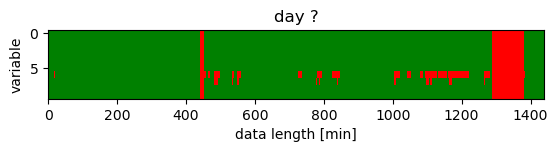

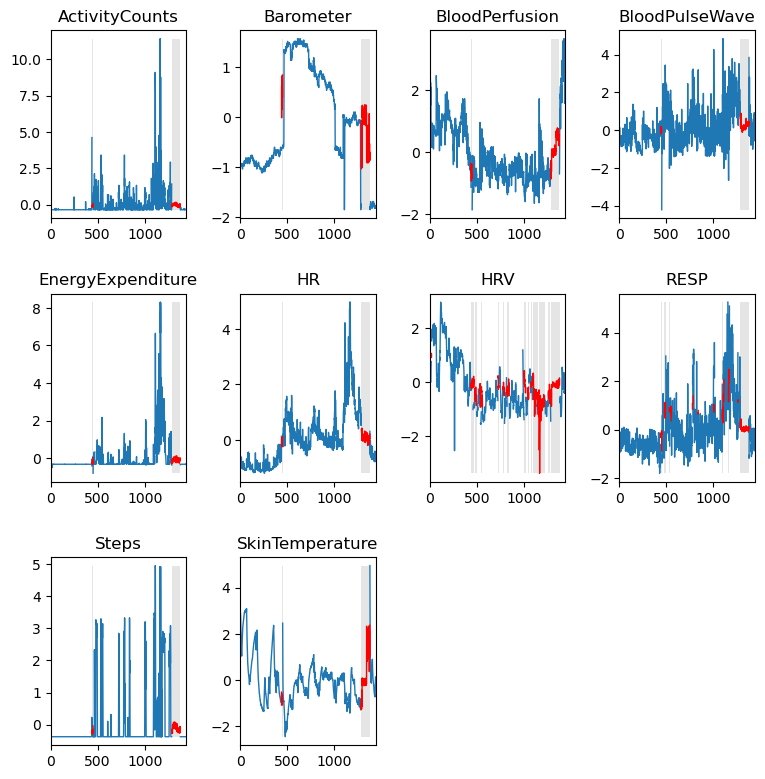

In [22]:
with torch.no_grad():
    sequence_length = model.max_len

    full_day = pd.DataFrame(test_data[0]).copy()
    mask = masker(full_day, lm=lm, masking_ratio=r)
    mask[mask == 1] = 0 # we don't mask additional segments during testing

    # reshape
    full_day = full_day.transpose().to_numpy() # pandas -> numpy + reshape
    mask = mask.transpose()

    # split day into batches
    n_batches = full_day.shape[0] // sequence_length
    batch = np.array([full_day[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])
    mask = np.array([mask[(i * sequence_length):((i + 1) * sequence_length), :] for i in range(n_batches)])

    # mask missing data
    y_true = torch.tensor(batch).float().to(device) # target values shouldn't be masked
    batch[mask.astype(bool)] = 0.0 # missing data -> 0.0 for transformer
    batch = torch.tensor(batch).float().to(device) # array -> tensor + add batch dimension
    X = batch

    # predict
    y_pred = model(X, padding_masks=torch.ones(n_batches, sequence_length).bool().to(device)) # padding mask all True

    # put back into cpu
    y_true = y_true.to('cpu')
    y_pred = y_pred.to('cpu')

    # concatenate batches into full day sequence
    y = y_true[0, :, :].numpy()
    for i in range(1, y_true.shape[0]):
        y = np.concatenate((y, y_true[i, :, :].numpy()), axis=0)
    y = y.transpose()

    yp = y_pred[0, :, :].detach().numpy()
    for i in range(1, y_pred.shape[0]):
        yp = np.concatenate((yp, y_pred[i, :, :].detach().numpy()), axis=0)
    yp = yp.transpose()

    m = mask[0, :, :]
    for i in range(1, mask.shape[0]):
        m = np.concatenate((m, mask[i, :, :]), axis=0)
    m = m.transpose()

    # visualize mask
    if show_mask:
        visualize_mask(m, '?')

    # plot imputation
    plt.figure()
    plt.subplots_adjust(left=0.1,
                        bottom=0.01,
                        right=1.2,
                        top=1.5,
                        wspace=0.4,
                        hspace=0.4)

    if prediction_only:
        for i, variable in enumerate(VARIABLES):
            mask_variable = m[i, :] # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)
            time_series_imputed = yp[i, :]
            if not full_prediction:
                time_series_imputed[mask_variable != 2] = np.NaN # remove data we know anyway

            plt.subplot(3, 4, i+1)
            if show_mask_plot:
                y_min, y_max = np.nanmin(time_series_imputed), np.nanmax(time_series_imputed)
                masked = mask_variable != 0
                # build continuous masking sequences for plot
                seq = []
                for j in range(len(masked)):
                    if masked[j] and j != (len(masked) - 1): # True means datapoint is masked
                        seq.append(j)
                    else:
                        if len(seq) != 0:
                            # plot background
                            plt.axhspan(y_min, y_max, seq[0] / 1440, seq[-1] / 1440, facecolor='grey', alpha=0.2)
                            seq = []
            plt.title(variable)
            plt.plot(time_series_imputed, color='red', linewidth=1)
            plt.xlim([0, 1440])
            plt.plot()
    else:
        for i, variable in enumerate(VARIABLES):
            mask_variable = m[i, :] # 0: available, 1: masked (purposefully set to NaN), 2: missing (NaN from beginning)
            time_series = y[i, :]
            time_series_imputed = yp[i, :]
            if not full_prediction:
                time_series_imputed[mask_variable != 2] = np.NaN # remove data we know anyway

            plt.subplot(3, 4, i+1)
            if show_mask_plot:
                y_min, y_max = min(np.nanmin(time_series), np.nanmin(time_series_imputed)), \
                               max(np.nanmax(time_series), np.nanmax(time_series_imputed))
                masked = mask_variable != 0
                # build continuous masking sequences for plot
                seq = []
                for j in range(len(masked)):
                    if masked[j] and j != (len(masked) - 1): # True means datapoint is masked
                        seq.append(j)
                    else:
                        if len(seq) != 0:
                            # plot background
                            plt.axhspan(y_min, y_max, seq[0] / 1440, seq[-1] / 1440, facecolor='grey', alpha=0.2)
                            seq = []
            plt.title(variable)
            plt.plot(time_series, linewidth=1)
            plt.plot(time_series_imputed, color='red', linewidth=1)
            plt.xlim([0, 1440])
            plt.plot()

Get prediction on test set

In [23]:
n_days = len(test_data)

# build masks
mask_shape = test_data[0].shape
masks = np.zeros((n_days, *mask_shape))
for day in range(n_days):
    masks[day] = masker(pd.DataFrame(test_data[day]), lm=lm, masking_ratio=r)

# score each imputation method
y_preds = np.array([])
y_trues = np.array([])
for day in range(n_days):
    data_day = pd.DataFrame(test_data[day]) # data for current day
    mask = masks[day] # mask for current day (all imputation methods use same masks)

    # impute masked data
    masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
    data_imputed = pd.DataFrame(masked_prediction(model, masked_data, device))

    # calculate error
    real_data = data_day.to_numpy()[mask == 1.0]
    imputed_data = data_imputed.to_numpy()[mask == 1.0]

    # save
    y_preds = np.concatenate([y_preds, imputed_data], axis=None)
    y_trues = np.concatenate([y_trues, real_data], axis=None)

Calculate metrics

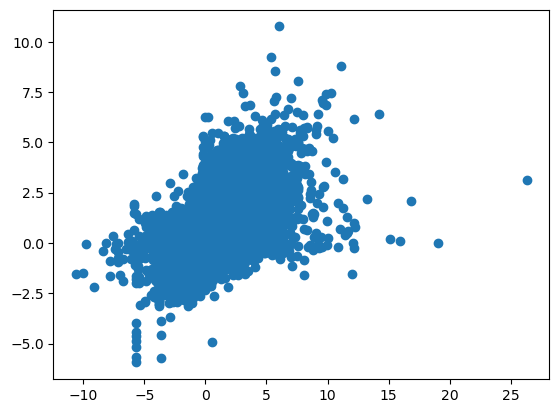

In [49]:
plt.scatter(x=y_trues, y=y_preds)

In [44]:
test_data = [pd.DataFrame(dat) for dat in test_data]

1. Performance scores

In [141]:
i = 0
n = 100
scores = []
while i < n:
    try:
        temp = test_imputation_methods(test_data,
                                       lm=lm,
                                       masking_ratio=r,
                                       model=model,
                                       device=device)
    except ValueError:
        continue
    if np.any(np.isnan(np.array([element[1] for element in temp]).ravel())):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: divide by zero encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: di

In [142]:
dictify = lambda x: [{vals[0]: vals[1] for vals in score} for score in x]
scores = dictify(scores)

In [143]:
scores

[{'transformer': (0.49761529626615625,
   2.601104040814163,
   0.7683655976996338,
   0.6412737124224793,
   0.6403678840379017),
  'linear': (0.5251587458395998,
   4.0653538515061065,
   0.9648768709474138,
   0.49345367839328974,
   0.6177417858427948),
  'nearest': (0.561137867188754,
   4.487039673502599,
   1.0709567843464773,
   0.4547074644055132,
   0.6018731941909512),
  'spline': (0.6505813694913141,
   3.2915876396741806,
   0.9803551723111482,
   0.3129517572452012,
   0.4099967535841081),
  'median': (0.6686783880884493,
   2.1792204962817014,
   1.0655247626969244,
   -0.11057181221818685,
   -0.032586075722125706),
  'mean': (0.7296611053175177,
   1.5245929552474122,
   1.0339992408612828,
   -0.26151126355314835,
   -0.297968249051605),
  'mode': (0.9655186179040083,
   7.460080556239189,
   1.5308385020335493,
   -0.028988067296910346,
   0.0033397078737923015),
  'quadratic': (94.42156404842949,
   310.3794097851243,
   3208.23669293788,
   -0.00358440225169896,
  

In [144]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
rows = []
for imputation_method in imputation_methods:
    meanify = lambda x: np.round(np.mean(x), ROUNDING)
    stdify = lambda x: np.round(np.std(x), ROUNDING)

    n_metrics = len(list(scores[0].values())[0])

    means = [meanify([score[imputation_method][i] for score in scores]) for i in range(n_metrics)]
    stds = [stdify([score[imputation_method][i] for score in scores]) for i in range(n_metrics)]

    # only for sorting later
    row = [means[0]]

    row += [str(mean) + ' ± ' + str(std) for mean, std in zip(means, stds)]
    rows.append(row)

table = pd.DataFrame(rows)
table.columns = ['temp', 'MAE', 'MRE', 'RMSE', 'r_{\mathrm{Pearson}}', '\\rho_{\mathrm{Spearman}}']
table.index = [imputation_method.capitalize() for imputation_method in imputation_methods]

In [145]:
# sort by MAE (mean)
table = table.sort_values(by=['temp'])
table = table.drop(columns=['temp'])
table

,MAE,MRE,RMSE,r_{\mathrm{Pearson}},\rho_{\mathrm{Spearman}}
Transformer,0.495 ± 0.005,3.094 ± 0.951,0.759 ± 0.008,0.649 ± 0.006,0.643 ± 0.006
Linear,0.511 ± 0.009,4.575 ± 1.324,0.957 ± 0.032,0.509 ± 0.017,0.626 ± 0.008
Nearest,0.548 ± 0.009,5.136 ± 1.546,1.064 ± 0.037,0.469 ± 0.017,0.607 ± 0.008
Median,0.668 ± 0.007,2.18 ± 0.348,1.06 ± 0.01,-0.096 ± 0.01,-0.019 ± 0.011
Spline,0.7 ± 0.133,3.956 ± 0.823,4.049 ± 11.157,0.204 ± 0.112,0.415 ± 0.01
Mean,0.729 ± 0.005,1.519 ± 0.179,1.027 ± 0.009,-0.254 ± 0.007,-0.281 ± 0.008
Mode,0.946 ± 0.016,7.556 ± 1.607,1.502 ± 0.028,-0.018 ± 0.01,0.015 ± 0.013
Quadratic,172.244 ± 102.692,1081.808 ± 1324.524,6644.463 ± 5308.724,0.002 ± 0.011,0.255 ± 0.013


In [146]:
# make smallest bold
for col in range(len(table.columns)):
    if col in (3, 4): # correlation: higher is better
        index_best = np.argmax([abs(float(entry.split('±')[0])) for entry in table.iloc[:, col]])
    else:
        index_best = np.argmin([float(entry.split('±')[0]) for entry in table.iloc[:, col]])
    entry = table.iloc[index_best, col]
    entry = 'BOLD{' + entry + '}'
    table.iloc[index_best, col] = entry

In [147]:
df = table
caption = f'Imputation metrics (n=100)'
print(
    df.to_latex(
        index=True,
        bold_rows=True,
        caption=caption,
        position='H').replace('BOLD\\', r'\textbf').replace('\}', '}').replace('\_', '_').replace('\\textbackslash', '\\').replace(r'\{', r'{').replace('\\ ', '\\')
)

\begin{table}[H]
\centering
\caption{Imputation metrics (n=100)}
\begin{tabular}{llllll}
\toprule
{} &                  MAE &                  MRE &                 RMSE & r_{\mathrm{Pearson}} & \rho_{\mathrm{Spearman}} \\
\midrule
\textbf{Transformer} &  \textbf{0.495 ± 0.005} &        3.094 ± 0.951 &  \textbf{0.759 ± 0.008} &  \textbf{0.649 ± 0.006} &      \textbf{0.643 ± 0.006} \\
\textbf{Linear     } &        0.511 ± 0.009 &        4.575 ± 1.324 &        0.957 ± 0.032 &        0.509 ± 0.017 &            0.626 ± 0.008 \\
\textbf{Nearest    } &        0.548 ± 0.009 &        5.136 ± 1.546 &        1.064 ± 0.037 &        0.469 ± 0.017 &            0.607 ± 0.008 \\
\textbf{Median     } &        0.668 ± 0.007 &         2.18 ± 0.348 &          1.06 ± 0.01 &        -0.096 ± 0.01 &           -0.019 ± 0.011 \\
\textbf{Spline     } &          0.7 ± 0.133 &        3.956 ± 0.823 &       4.049 ± 11.157 &        0.204 ± 0.112 &             0.415 ± 0.01 \\
\textbf{Mean       } &        0.729 ± 0.0

C:\Users\jjung\AppData\Local\Temp\ipykernel_15212\452253745.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


In [149]:
scores_all = scores
tables_all = table

2. Imputation by variable

In [135]:
def test_imputation_methods_by_variable(dat: list, lm=3, masking_ratio=0.15, model=None, device=None):
    """
    Tests all imputation methods
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mean absolute error (MAE) & mean relative error (MRE) on masked data (sorted dict)
    """
    n_days = len(dat)
    imputation_methods = ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest') if model is None else \
        ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest', 'transformer')

    # build masks
    mask_shape = dat[0].shape
    masks = np.zeros((n_days, *mask_shape))
    for day in range(n_days):
        masks[day] = masker(dat[day], lm=lm, masking_ratio=masking_ratio)

    # score each imputation method
    scores = {imputation_method: {variable: None for variable in VARIABLES} for imputation_method in imputation_methods}
    for imputation_method in imputation_methods:
        y_preds = {variable: np.array([]) for variable in VARIABLES}
        y_trues = {variable: np.array([]) for variable in VARIABLES}
        for day in range(n_days):
            data_day = dat[day] # data for current day
            mask = masks[day] # mask for current day (all imputation methods use same masks)

            # impute masked data
            masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
            data_imputed = imputer(masked_data, imputation_method, order=2, model=model, device=device) # order for spline, device for transformer

            # save
            for i, variable in enumerate(VARIABLES):
                real_data_var = data_day.to_numpy()[i, :][mask[i, :] == 1.0]
                imputed_data_var = data_imputed.to_numpy()[i, :][mask[i, :] == 1.0]

                y_preds[variable] = np.concatenate([y_preds[variable], imputed_data_var], axis=None)
                y_trues[variable] = np.concatenate([y_trues[variable], real_data_var], axis=None)

        for variable in VARIABLES:
            y_trues_var = y_trues[variable]
            y_preds_var = y_preds[variable]

            mae_ = mae(y_trues_var, y_preds_var)
            mre_ = mre(y_trues_var, y_preds_var)
            rmse_ = rmse(y_trues_var, y_preds_var)
            pearson_corr_ = pearson_corr(y_trues_var, y_preds_var)
            spearman_corr_ = spearman_corr(y_trues_var, y_preds_var)

            scores[imputation_method][variable] = (mae_, mre_, rmse_, pearson_corr_, spearman_corr_)

    return scores

In [136]:
i = 0
n = 100
scores = []
while i < n:
    try:
        temp = test_imputation_methods_by_variable(test_data,
                                                   lm=lm,
                                                   masking_ratio=r,
                                                   model=model,
                                                   device=device)
    except ValueError:
        continue

    values = [list(temp[method][variable]) for method in temp.keys() for variable in temp[method].keys()]
    if np.any(np.isnan(values)):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: divide by zero encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(y_trues))
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: di

In [137]:
scores

[{'mean': {'ActivityCounts': (0.577028574036915,
    1.0986561937713866,
    1.030869872054979,
    -0.16216120655914026,
    -0.188092400326965),
   'Barometer': (0.8571796585794985,
    1.1707504472753376,
    1.0318460258364335,
    -0.29079545656979133,
    -0.3178348229873421),
   'BloodPerfusion': (0.8710981205859858,
    1.2731753436866755,
    1.076214623883953,
    -0.29910631598711607,
    -0.3193354509816525),
   'BloodPulseWave': (0.7632712517969458,
    1.4863642287539822,
    1.012875698497522,
    -0.22087375712428495,
    -0.26068570474530556),
   'EnergyExpenditure': (0.6374659827900084,
    1.139996943190404,
    1.0795535412139665,
    -0.22553143267076117,
    -0.20022993003844378),
   'HR': (0.8180192325008069,
    1.8133663845449917,
    1.0585380165471956,
    -0.2628346564568839,
    -0.2982705224548057),
   'HRV': (0.801597959276951,
    2.8116684597720822,
    1.008564189082814,
    -0.26088794426187,
    -0.27034275221732545),
   'RESP': (0.7701497297430118,


In [138]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
for imputation_method in imputation_methods:
    rows = []
    for variable in VARIABLES:
        meanify = lambda x: np.round(np.mean(x), ROUNDING)
        stdify = lambda x: np.round(np.std(x), ROUNDING)

        n_metrics = len(scores[0]['mean'][VARIABLES[0]])

        means = [meanify([score[imputation_method][variable][i] for score in scores]) for i in range(n_metrics)]
        stds = [stdify([score[imputation_method][variable][i] for score in scores]) for i in range(n_metrics)]

        # only for sorting later
        row = [means[0]]

        row += [str(mean) + ' ± ' + str(std) for mean, std in zip(means, stds)]
        rows.append(row)

    table = pd.DataFrame(rows)
    table.columns = ['temp', 'MAE', 'MRE', 'RMSE', 'r_{\mathrm{Pearson}}', '\\rho_{\mathrm{Spearman}}']
    table.index = [variable for variable in VARIABLES]

    # sort by MAE (mean)
    table = table.sort_values(by=['temp'])
    table = table.drop(columns=['temp'])

    # make smallest bold
    for col in range(len(table.columns)):
        if col in (3, 4): # correlation: higher is better
            index_best = np.argmax([abs(float(entry.split('±')[0])) for entry in table.iloc[:, col]])
        else:
            index_best = np.argmin([float(entry.split('±')[0]) for entry in table.iloc[:, col]])
        entry = table.iloc[index_best, col]
        entry = 'BOLD{' + entry + '}'
        table.iloc[index_best, col] = entry

    tables.append(table)

In [139]:
for i, imputation_method in enumerate(imputation_methods):
    df = tables[i]
    caption = r'\textbf{' + imputation_method.capitalize() + '}'
    caption += f'-imputation by variable (n=100)'
    print(
        df.to_latex(
            index=True,
            bold_rows=True,
            caption=caption,
            position='H').replace('BOLD\\', r'\textbf').replace('\}', '}').replace('\_', '_').replace('\\textbackslash', '\\').replace(r'\{', r'{').replace('\\ ', '\\')
    )

\begin{table}[H]
\centering
\caption{\textbf{Mean}-imputation by variable (n=100)}
\begin{tabular}{llllll}
\toprule
{} &                  MAE &                 MRE &                 RMSE & r_{\mathrm{Pearson}} & \rho_{\mathrm{Spearman}} \\
\midrule
\textbf{Steps            } &  \textbf{0.464 ± 0.014} &  \textbf{1.046 ± 0.03} &  \textbf{0.983 ± 0.042} &       -0.179 ± 0.017 &           -0.154 ± 0.082 \\
\textbf{ActivityCounts   } &        0.568 ± 0.011 &       1.141 ± 0.049 &        1.013 ± 0.033 &       -0.168 ± 0.016 &           -0.187 ± 0.042 \\
\textbf{EnergyExpenditure} &        0.609 ± 0.016 &        1.16 ± 0.118 &        1.025 ± 0.041 &       -0.215 ± 0.018 &            -0.199 ± 0.05 \\
\textbf{RESP             } &        0.758 ± 0.011 &       1.545 ± 0.238 &        1.019 ± 0.017 &       -0.197 ± 0.017 &           -0.219 ± 0.019 \\
\textbf{BloodPulseWave   } &        0.759 ± 0.014 &        1.47 ± 0.209 &         1.02 ± 0.019 &        -0.21 ± 0.017 &            -0.234 ± 0.02 \\
\t

C:\Users\jjung\AppData\Local\Temp\ipykernel_15212\3364508060.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


In [140]:
scores_var = scores
tables_var = tables

3. Imputation by sequence length

In [121]:
def test_imputation_methods_by_sequence(dat: list, lm=3, masking_ratio=0.15, model=None, device=None):
    """
    Tests all imputation methods
    :param dat: data by day (!)
    :param lm: mean sequence length
    :param masking_ratio: ratio of masking/non-masking
    :return: mean absolute error (MAE) & mean relative error (MRE) on masked data (sorted dict)
    """
    n_days = len(dat)
    imputation_methods = ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest') if model is None else \
        ('mean', 'median', 'mode', 'linear', 'quadratic', 'spline', 'nearest', 'transformer')

    # build masks
    mask_shape = dat[0].shape
    masks = np.zeros((n_days, *mask_shape))
    for day in range(n_days):
        masks[day] = masker(dat[day], lm=lm, masking_ratio=masking_ratio)

    # score each imputation method
    scores = {imputation_method: {'small': None, 'medium': None, 'long': None} for imputation_method in imputation_methods}
    for imputation_method in imputation_methods:
        imputations = []
        reals = [] # for MRE
        for day in range(n_days):
            data_day = dat[day] # data for current day
            mask = masks[day] # mask for current day (all imputation methods use same masks)

            # impute masked data
            masked_data = pd.DataFrame(np.where(mask == 1.0, np.NaN, data_day)) # masked -> NaN
            data_imputed = imputer(masked_data, imputation_method, order=2, model=model, device=device) # order for spline, device for transformer

            # calculate error
            for i, _ in enumerate(VARIABLES):
                mask_variable = mask[i, :] # mask for current variable
                imputed_variable = data_imputed.to_numpy()[i, :] # imputed data for current variable
                masked_elements = np.where(mask_variable == 1.0)[0] # boolean array, noting where data is imputed (imputed: 1.0)
                sequence_indices = np.split(masked_elements, np.where(np.diff(masked_elements) > 1)[0]) # indices for continuous imputation sequences
                for sequence in sequence_indices:
                    real = data_day.to_numpy()[i, :][sequence]
                    imputed = imputed_variable[sequence]

                    imputations.append(imputed)
                    reals.append(real)

        sequence_lengths = [len(seq) for seq in imputations]

        # we define long sequences as > 75th percentile, small sequences as < 25th percentile, medium sequences between 25th, 75th percentile
        long_sequence_threshold = np.percentile(sequence_lengths, 75)
        small_sequence_threshold = np.percentile(sequence_lengths, 25)

        long_sequences_selection = sequence_lengths > long_sequence_threshold # boolean masks
        small_sequences_selection = sequence_lengths < small_sequence_threshold # boolean masks
        medium_sequences_selection = (small_sequence_threshold < sequence_lengths) & (sequence_lengths < long_sequence_threshold) # boolean masks

        for name, selection in zip(('small', 'medium', 'long'), (small_sequences_selection, medium_sequences_selection, long_sequences_selection)):
            imputed_data = np.concatenate(np.array(imputations)[selection])
            real_data = np.concatenate(np.array(reals)[selection])

            y_trues = real_data
            y_preds = imputed_data

            mae_ = mae(y_trues, y_preds)
            mre_ = mre(y_trues, y_preds)
            rmse_ = rmse(y_trues, y_preds)
            pearson_corr_ = pearson_corr(y_trues, y_preds)
            spearman_corr_ = spearman_corr(y_trues, y_preds)

            scores[imputation_method][name] = (mae_, mre_, rmse_, pearson_corr_, spearman_corr_)

    return scores

In [122]:
i = 0
n = 100
scores = []
while i < n:
    try:
        temp = test_imputation_methods_by_sequence(test_data,
                                                   lm=lm,
                                                   masking_ratio=r,
                                                   model=model,
                                                   device=device)
    except ValueError:
        continue

    values = [list(temp[method][sequence]) for method in temp.keys() for sequence in temp[method].keys()]
    if np.any(np.isnan(values)):
        pass
    else:
        scores.append(temp)
        i += 1

C:\Users\jjung\AppData\Local\Temp\ipykernel_15212\966842015.py:56: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  imputed_data = np.concatenate(np.array(imputations)[selection])
C:\Users\jjung\AppData\Local\Temp\ipykernel_15212\966842015.py:57: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  real_data = np.concatenate(np.array(reals)[selection])
C:\Users\jjung\OneDrive\Dokumente\ETH\MSc 3rd semester\Semester project\imputation_utils.py:412: RuntimeWarning: invalid value encountered in true_divide
  relative_abs_errors = np.divide(np.abs(errors), np.abs(

In [123]:
scores

[{'mean': {'small': (0.8750309915444588,
    1.1449364793839878,
    1.2894280611954891,
    -0.054866224217118134,
    -0.05951330730091203),
   'medium': (0.7370535926196161,
    1.5454219545889207,
    1.0353993087215567,
    -0.13760224799037304,
    -0.14917264001511876),
   'long': (0.7169644947797251,
    1.816453032022086,
    0.9910631067322921,
    -0.33423174106536785,
    -0.372414920545056)},
  'median': {'small': (0.8316193273699692,
    1.3411284132792338,
    1.323368161579498,
    -0.057914847150984654,
    0.02324451601396199),
   'medium': (0.6825964895774942,
    1.8913869954565445,
    1.0694622382664316,
    -0.04242014797264228,
    0.04198553541748292),
   'long': (0.6558789166341255,
    3.1146043265162047,
    1.0273668512937086,
    -0.1528158733486802,
    -0.08414998471353037)},
  'mode': {'small': (1.1658728996507777,
    4.890666263539724,
    1.8383095818076294,
    -0.060648142801714364,
    -0.024860603826756783),
   'medium': (0.9805260405184001,
    

In [130]:
# get means
ROUNDING = 3
tables = []
imputation_methods = list(scores[0].keys())
for imputation_method in imputation_methods:
    rows = []
    for sequence in ('small', 'medium', 'long'):
        meanify = lambda x: np.round(np.mean(x), ROUNDING)
        stdify = lambda x: np.round(np.std(x), ROUNDING)

        n_metrics = len(scores[0]['mean']['small'])

        means = [meanify([score[imputation_method][sequence][i] for score in scores]) for i in range(n_metrics)]
        stds = [stdify([score[imputation_method][sequence][i] for score in scores]) for i in range(n_metrics)]

        # only for sorting later
        row = [means[0]]

        row += [str(mean) + ' ± ' + str(std) for mean, std in zip(means, stds)]
        rows.append(row)

    table = pd.DataFrame(rows)
    table.columns = ['temp', 'MAE', 'MRE', 'RMSE', 'r_{\mathrm{Pearson}}', '\\rho_{\mathrm{Spearman}}']
    table.index = ['Small sequences', 'Medium sequences', 'Long sequences']

    # sort by MAE (mean)
    table = table.sort_values(by=['temp'])
    table = table.drop(columns=['temp'])

    # make smallest bold
    for col in range(len(table.columns)):
        if col in (3, 4): # correlation: higher is better
            index_best = np.argmax([abs(float(entry.split('±')[0])) for entry in table.iloc[:, col]])
        else:
            index_best = np.argmin([float(entry.split('±')[0]) for entry in table.iloc[:, col]])
        entry = table.iloc[index_best, col]
        entry = 'BOLD{' + entry + '}'
        table.iloc[index_best, col] = entry

    tables.append(table)

In [125]:
for i, imputation_method in enumerate(imputation_methods):
    df = tables[i]
    caption = r'\textbf{' + imputation_method.capitalize() + '}'
    caption += f'-imputation by sequence length (n=100)'
    print(
        df.to_latex(
            index=True,
            bold_rows=True,
            caption=caption,
            position='H').replace('BOLD\\', r'\textbf').replace('\}', '}').replace('\_', '_').replace('\\textbackslash', '\\').replace(r'\{', r'{').replace('\\ ', '\\')
    )

\begin{table}[H]
\centering
\caption{\textbf{Mean}-imputation by sequence length (n=100)}
\begin{tabular}{llllll}
\toprule
{} &                 MAE &                  MRE &                RMSE & r_{\mathrm{Pearson}} & \rho_{\mathrm{Spearman}} \\
\midrule
\textbf{Long sequences  } &  \textbf{0.72 ± 0.008} &         1.62 ± 0.273 &  \textbf{1.01 ± 0.014} &  \textbf{-0.33 ± 0.013} &     \textbf{-0.365 ± 0.013} \\
\textbf{Medium sequences} &       0.736 ± 0.009 &        1.455 ± 0.242 &       1.041 ± 0.015 &       -0.132 ± 0.016 &           -0.149 ± 0.017 \\
\textbf{Small sequences } &       0.853 ± 0.018 &  \textbf{1.296 ± 0.224} &       1.236 ± 0.037 &       -0.018 ± 0.026 &           -0.027 ± 0.027 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}[H]
\centering
\caption{\textbf{Median}-imputation by sequence length (n=100)}
\begin{tabular}{llllll}
\toprule
{} &                  MAE &                  MRE &                 RMSE & r_{\mathrm{Pearson}} & \rho_{\mathrm{Spearman}} \\
\mi

C:\Users\jjung\AppData\Local\Temp\ipykernel_15212\276566941.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex(


In [131]:
scores_seq = scores
tables_seq = tables

Store all scores/tables

In [159]:
save_path = './Scores/imputation/'

In [158]:
"""i = 0

for table, scor in zip(tables_seq, scores_seq):
    #np.save(scor, save_path + str(i))
    table.to_csv(save_path + str(i) + '.csv')
    i += 1

for table, scor in zip(tables_var, scores_var):
    #np.save(scor, save_path + str(i))
    table.to_csv(save_path + str(i) + '.csv')
    i += 1

#np.save(scores_all, save_path + str(i))
tables_all.to_csv(save_path + str(i) + '.csv')"""

In [165]:
for imputation_method, table in zip(list(scores_seq[0].keys()), tables_seq):
    table.to_csv(save_path + 'imputation_by_sequence_' + str(imputation_method) + '.csv')

In [168]:
for imputation_method, table in zip(list(scores_var[0].keys()), tables_var):
    table.to_csv(save_path + 'imputation_by_variable_' + str(imputation_method) + '.csv')

In [ ]:
tables_all.to_csv(save_path + 'imputation_all_methods' + '.csv')